In [32]:
# import the modules
import urllib.request
import networkx as nx
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt 
from node2vec import Node2Vec 
 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve
import matplotlib.pyplot as plt

In [33]:
#Load the dataset
# Define the URL of the edge list file for the Facebook-Ego network
facebook_url = "https://raw.githubusercontent.com/wang422003/Complex-Networks_exercise/main/Datasets/Group3/Facebook-Ego/348.edges"
# Download the Facebook-Ego network file
urllib.request.urlretrieve(facebook_url, "facebook.edges")
# Load the Facebook-Ego network (undirect graph)
facebook_network = nx.read_edgelist("facebook.edges", nodetype=int)

# Define the URL of the edge list file for the Twitter-Ego network
twitter_url = "https://raw.githubusercontent.com/wang422003/Complex-Networks_exercise/main/Datasets/Group3/Twitter-Ego/789071.edges"
# Download the Twitter-Ego network file
urllib.request.urlretrieve(twitter_url, "twitter.edges")
# Load the Twitter-Ego network (direct graph)
twitter_network = nx.read_edgelist("twitter.edges", nodetype=int, create_using=nx.DiGraph())

In [34]:
# Remove 10% of the edges
num_edges_to_remove = int(len(facebook_network.edges()) * 0.1)
removed_edges = random.sample(facebook_network.edges(), num_edges_to_remove)
facebook_network.remove_edges_from(removed_edges)

/tmp/ipykernel_15407/2589287146.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  removed_edges = random.sample(facebook_network.edges(), num_edges_to_remove)


In [35]:
# Generate node embeddings using node2vec
node2vec = Node2Vec(facebook_network, dimensions=64, walk_length=10, num_walks=50, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 122.31it/s]


In [36]:
# Function to extract features
def get_features(edge_list):
    return [model.wv[str(u)] + model.wv[str(v)] for u, v in edge_list]

In [37]:
# Prepare Training and Testing Data
train_non_edges = random.sample(list(nx.non_edges(facebook_network)), len(facebook_network.edges()) - len(removed_edges))
train_set = list(facebook_network.edges()) + train_non_edges
test_set = removed_edges + random.sample(list(nx.non_edges(facebook_network)), len(removed_edges))
train_labels = [1] * len(facebook_network.edges()) + [0] * len(train_non_edges)
test_labels = [1] * len(removed_edges) + [0] * len(removed_edges)

In [38]:
train_features = get_features(train_set)
test_features = get_features(test_set)

In [39]:
# Train Logistic Regression Model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(train_features, train_labels)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
# Predict and Evaluate
pred_probs = clf.predict_proba(test_features)[:, 1]
accuracy = accuracy_score(test_labels, (pred_probs >= 0.5).astype(int))
auroc = roc_auc_score(test_labels, pred_probs)
precision = precision_score(test_labels, (pred_probs >= 0.5).astype(int))

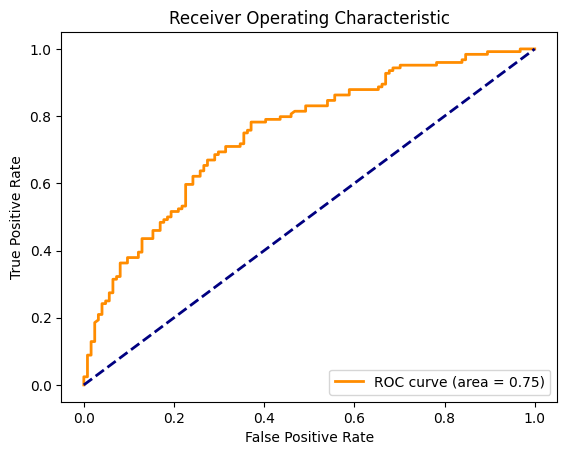

In [41]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [42]:
# Print the Metrics
print(f"Accuracy: {accuracy}")
print(f"AUROC: {auroc}")
print(f"Precision: {precision}")

Accuracy: 0.6814516129032258
AUROC: 0.7496748178980228
Precision: 0.6470588235294118
